# REDUCCION DE DIMENSIONALIDAD

Muchos de los problemas de Machine Learning implican miles e incluso millones de características por cada instancia de entrenamiento. Esto no solo hace que el entrenamiento sea extremadamente lento sino que, como veremos, también puede hacer mucho más difícil encontrar una buena solución. A menudo este problema es referido como la *maldición de la dimensionalidad*.

Afortunadamente, en los problemas del mundo real, a menudo es posible reducir considerablemente el número de características, convirtiendo un problema intratable en uno manejable. Por ejemplo, consideremos las imágenes MNIST (que vimos en el capítulo 3): los píxeles de los bordes de la imagen son casi siempre blancos, por lo que podríamos eliminarlos completamente del conjunto de entrenamiento sin perder mucha información. La siguiente figura ya nos confirmó que dichos píxeles no son importantes en absoluto para la tarea de clasificación. Además, dos píxeles vecinos a menudo están altamente correlacionados: si los combinamos en un único píxel (por ejemplo, tomando la media de las intensidades de los dos píxeles) no perderemos mucha información.

![mnist_pixel_importance](images/ch07/mnist_pixel_importance.png)

---

La reducción de la dimensionalidad pierde algo de información (al igual que comprimir una imagen a JPEG puede degradar su calidad), por lo que, aunque acelerará el entrenamiento, también puede hacer que nuestro sistema se ejecute peor. También hace nuestros pipelines un poco más complejos y, por tanto, difíciles de mantener. Por lo tanto, primero deberíamos intentar entrenar nuestro sistema con los datos originales antes de considerar el uso de la reducción de la dimensionalidad si el entrenamiento es demasiado lento. En algunos casos, sin embargo, reducir la dimensionalidad de los datos de entrenamiento pueden filtrar algún ruido y detalles innecesarios y, por tanto, resultar en una mayor ejecución (pero en general no es así, solo acelerará el entrenamiento).

---

Además de acelerar el entrenamiento, la reducción de dimensionalidad también es extremadamente útil para la visualización de datos (o *DataViz*). Reducir el número de dimensiones a dos (o tres) hace posible elaborar en un gráfico una vista condensada de un conjunto de entrenamiento de gran dimensionalidad y, a menudo, conseguir ideas importantes detectando patrones visualmente, tales como clusters. Además, DataViz es esencial para comunicar nuestras conclusiones a personas que no son científicos de datos, en particular responsables de tomar decisiones que usarán nuestros resultados.

En este capítulo discutiremos la maldición de la dimensionalidad y tendremos una idea de lo que sucede en el espacio de alta dimensionalidad. Después, presentaremos los dos principales enfoques de la reducción de dimensionalidad (proyección y Manifold Learning) e iremos a través de las tres técnicas más populares de reducción de dimensionalidad: PCA, Kernel PCA y LLE.

# La maldición de la dimensionalidad

Estamos tan acostumbrados a vivir en tres dimensiones (bueno, cuatro dimensiones si contamos el tiempo y algunas más si eres un teórico de cuerdas), que nuestra intuición nos falla cuando intentamos imaginar un espacio de alta dimensionalidad. Incluso un básico hipercubo 4D es increiblemente difícil de dibujar en nuestra mente (veamos la siguiente figura), mucho menos un elipsoide 200D doblado en un espacio 100D.

***Punto, segmento, cuadrado, cubo y [tesseract](https://homl.info/30) (hipercubos 0D a 4D)***

![hypercube](images/ch08/hypercube.png)

Resulta que muchas cosas se comportan muy diferentemente en un espacio de alta dimensionalidad. Por ejemplo, si seleccionamos un punto aleatorio en un cuadrado unitario (un cuadrado 1 x 1), tendremos solo una probabilidad del 0,4% de que esté localizado a 0.001 de un borde (en otras palabras, es muy improbable que un punto aleatorio sea "extremo" a lo largo de cualquier dimensión). Pero en un hipercubo unitario 10.000D (un cubo de 1 x 1 x ... 1, con diezmil unos), esta probabilidad es mayor que 99,999999%. La mayoría de los puntos en un hipercubo de alta dimensión están muy cerca del borde. *Dato curioso: cualquier persona que conozca es probablemente extremista en al menos una dimensión (por ejemplo, la cantidad de azúcar que ponen en su café), si se consideran suficientes dimensiones.*

Aquí hay una diferencia más problemática: si seleccionamos aleatoriamente dos puntos en un cuadrado unitario, la distancia entre ambos puntos será, de media, alrededor de 0,52. Si seleccionamos aleatoriamente dos puntos en un cubo unitario 3D, la distancia media será aproximadamente 0,66. Pero ¿qué pasa si seleccionamos aleatoriamente dos puntos en un hipercubo 1.000.000D? Bueno, lo creas o no, será alrededor de 408,25 (aproximadamente $\sqrt{\frac{1.000.000}{6}}$). Esto es bastante contraintuitivo: ¿cómo pueden estar dos puntos tan separados cuando están dentro del mismo hipercubo unitario? Este hecho implica que los datasets de alta dimensionalidad corren el riesgo de ser muy dispersos: la mayoría de las instancias de entrenamiento estarán probablemente muy lejos las unas de las otras. Por supuesto, esto también significa que una nueva instancia estará probablemente lejos de cualquier instancia de entrenamiento, lo que hace que las predicciones sean mucho menos confiables que en menores dimensiones, ya que se basarán en extrapolaciones mucho más grandes. En resumen, cuantas más dimensiones tenga el conjunto de entrenamiento, mayor será el riesgo de sobreajustarlo.

En teoría, una solución a la maldición de la dimensionalidad podría ser incrementar el tamaño del conjunto de entrenamiento para alcanzar una densidad suficiente de instancias de entrenamiento. Desafortunadamente, en la práctica el número de instancias requeridas para alcanzar una densidad dada crece exponencialmente con el número de dimensiones. Con solo 100 características (muchas menos que el problema MNIST), necesitaríamos más instancias de entrenamiento que átomos en el universo observable para que las instancias de entrenamiento estuvieran a una distancia unas de otras de 0,1 de media, asumiendo que se extendieran uniformemente a través de todas las dimensiones.

# Principales enfoques de la Reducción de Dimensionalidad

Antes de sumergirnos en los algoritmos específicos de reducción de la dimensionalidad, echemos un vistazo a los dos principales enfoques: proyección y Manifold Learning.

## Proyección

En la mayoría de los problemas del mundo real, las instancias de entrenamiento no se distribuyen de manera uniforme a través de todas las dimensiones. Muchas características son casi constantes, mientras que otras están altamente correlacionadas (como se discutió anteriormente para MNIST). Como resultado, todas las instancias de entrenamiento se encuentran realmente dentro (o cerca) de un *subespacio* de dimensiones mucho más bajas del espacio de alta dimensionalidad. Esto suena muy abstracto, así que veamos un ejemplo. En la siguiente figura podemos ver un dataset 3D representado por los círculos.

![dataset_3d_plot](images/ch08/dataset_3d_plot.png)

Observemos que todas las instancias de entrenamiento se encuentran cerca de un plano: este es un subespacio de menor dimensión (2D) del espacio de alta dimensión (3D). Ahora si proyectamos cada instancia de entrenamiento perpendicularmente en este subespacio (como se representa por las líneas cortas conectando las instancias al plano), obtenemos el nuevo dataset 2D mostrado en la siguiente figura. ¡Tachán! Acabamos de reducir la dimensión del dataset de 3D a 2D. Observemos que los ejes corresponden a nuevas características $z_1$ y $z_2$ (las coordenadas de las proyecciones en el plano).

![projection_2d](images/ch08/projection_2d.png)

Sin embargo, las proyecciones no siempre son la mejor aproximación a la reducción de la dimensionalidad. En muchos casos el subespacio puede girar y voltear, como el famoso dataset de juguete *rollo suizo* representado en la siguiente figura.

![swiss_roll](images/ch08/swiss_roll.png)

Simplemente proyectar en un plano (por ejemplo, eliminando $x_3$) aplastaría diferentes capas del rollo suizo, como se muestra a la izquierda de la siguiente figura. Sin embargo, lo que realmente deseamos es desenrollar el rollo suizo para obtener el conjunto de datos 2D a la derecha de la figura.

![unrolling_roll](images/ch08/unrolling_roll.png)

## Manifold Learning

Este rollo suizo es un ejemplo de *manifold* 2D. En pocas palabras, un manifold 2D es una forma 2D que puede ser doblada y girada en un espacio de alta dimensión. Más generalmente, un manifold *d*-dimensional es una parte de un espacio *n*-dimensional (donde *d* < *n*) que localmente se asemeja a un hiperplano *d*-dimensional. En el caso del rollo suizo, *d* = 2 y *n* = 3: localmente se asemeja a un plano 2D, pero está enrollado en tres dimensiones.

La mayoría de los algoritmos de reducción de dimensionalidad trabajan modelando el *manifold* en el cual se encuentran las instancias de entrenamiento; esto se denomina *Manifold Learning*. Se basa en la *asunción manifold*, también denominada la *hipótesis manifold*, que mantiene que la mayoría de los datasets del mundo real de alta dimensión se encuentran cerca de un manifold de dimensión mucho más baja. Esta suposición se observa muy a menudo empíricamente.

Una vez más pensemos en el dataset MNIST: todas las imágenes de dígitos escritos a mano tienen alguna similitud. Están hechas de líneas conectadas, los bordes son blancos y están más o menos centrados, etc. Si generamos aleatoriamente imágenes, solo una fracción ridículamente pequeña de ellas se parecería a dígitos escritos a mano. En otras palabras, los grados de libertad disponibles que tenemos si intentamos crear una imagen de un dígito es dramáticamente menor que los grados de libertad que tenemos si nos permitieran generar cualquier imagen que queramos. Estas restricciones tienen a apretar el dataset en un manifold de dimensiones bajas.

La asunción del manifold a menudo es acompañada por otra asunción implícita: que la tarea en cuestión (por ejemplo, clasificación o regresión) será más simple si se expresa en el espacio de menor dimensión del manifold. Por ejemplo, en la fila de arriba de la siguiente figura el rollo suizo está divido en dos clases: en el espacio 3D (a la izquierda), el limite de decisión sería bastante complejo, pero en el manifold desenrrollado en el espacio 2D (a la derecha), el límite de decisión es una simple línea recta.

![manifold_decision_boundary](images/ch08/manifold_decision_boundary.png)

Sin embargo, esta asunción no siempre es válida. Por ejemplo, en la fila inferior el límite de decisión está localizado en $x_1 = 5$. Este límite de decisión parece muy simple en el espacio 3D (un plano vertical), pero parece más complejo en el manifold desenrrollado (una colección de cuatro segmentos de línea independientes).

En resumen, si reducimos la dimensionalidad de nuestro conjunto de entrenamiento antes de entrenar un modelo, generalmente aceleraremos su entrenamiento, pero puede que no siempre nos conduzca a una mejor o más simple solución; depende del dataset.

Esperemos que ahora tengas una buena idea de qué es la maldición de la dimensionalidad y cómo los algoritmos de reducción de la dimensionalidad pueden combatirla, especialmente cuando se cumple la asunción de manifold. En el resto de este capítulo recorreremos algunos de los más populares algoritmos.

Veamos cómo hemos contruido las gráficas anteriores:

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
# Contruimos el dataset 3D

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

PCA usando descomposición SVD

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

Con Scikit-Learn, PCA es realmente trivial. Incluso se preocupa de centrar la media por nosotros:

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Tengamos en cuenta que ejecutar PCA varias veces en conjuntos de datos ligeramente diferentes puede dar como resultado resultados diferentes. En general, la única diferencia es que algunos ejes pueden voltearse. En este ejemplo, PCA que usa Scikit-Learn ofrece la misma proyección que la que ofrece el enfoque SVD, excepto que ambos ejes están invertidos:

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

Recupera los puntos 3D proyectados en el plano (subespacio 2D PCA)

In [12]:
X3D_inv = pca.inverse_transform(X2D)

Por supuesto, hubo cierta pérdida de información durante el paso de proyección, por lo que los puntos 3D recuperados no son exactamente iguales a los puntos 3D originales:

In [13]:
np.allclose(X3D_inv, X)

False

Calculamos el error de reconstrucción:

In [14]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

La transformación inversa en el enfoque SVD se ve así:

In [15]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

Las reconstrucciones de ambos métodos no son idénticas porque la clase `PCA` de Scikit-Learn se encarga automáticamente de revertir el centrado medio, pero si restamos la media, obtenemos la misma reconstrucción:

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

El objeto `PCA` da acceso a los componentes principales que calculó:

In [17]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Comparemos con los primeros dos componentes principales calculados usando el método SVD:

In [18]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Observe cómo se voltean los ejes.

Ahora veamos el ratio de varianza explicada:

In [19]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

La primera dimensión explica el 84.2% de la varianza, mientras que la segunda explica el 14.6%.

Al proyectar hacia abajo a 2D, perdimos alrededor del 1.1% de la varianza:

In [20]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Aquí se explica cómo calcular el ratio de varianza explicada utilizando el enfoque SVD (recuerda que `s` es la diagonal de la matriz `S`):

In [21]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

A continuación, ¡generemos algunas figuras bonitas!

Clase de utilidad para dibujar flechas 3D (copiado de http://stackoverflow.com/questions/11140163)

In [22]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Expresemos el plano como una función de x e y.

In [23]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Dibujemos el conjunto de datos 3D, el plano y las proyecciones en ese plano.

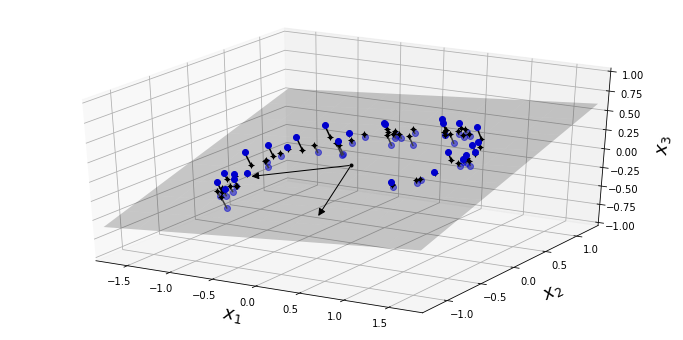

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

plt.show()

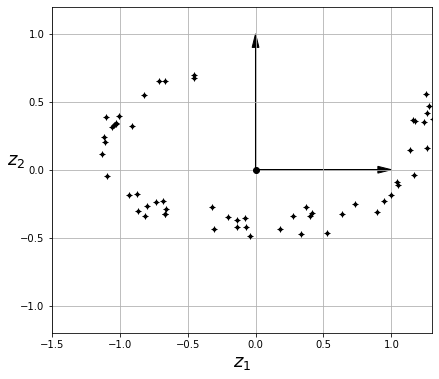

In [25]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True);

Rollo suizo

In [26]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

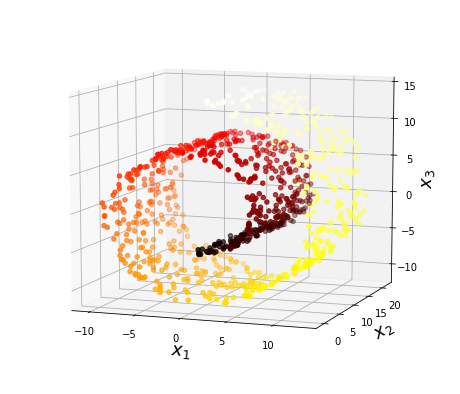

In [27]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

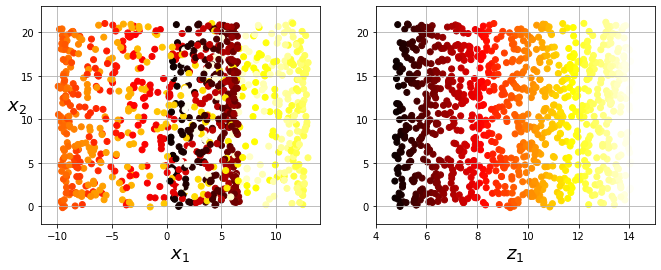

In [28]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

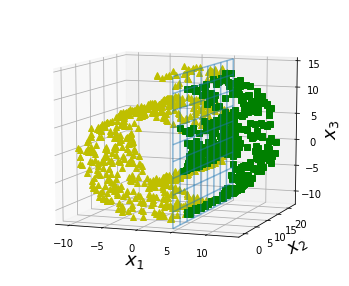

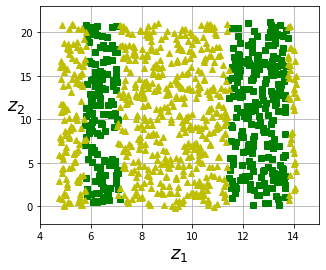

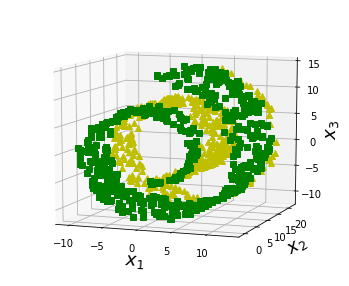

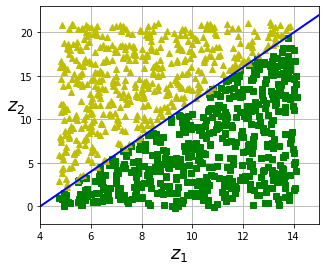

In [29]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

# PCA

El *Análisis de Componentes Principales* (PCA) es, con mucho, el algoritmo más popular de reducción de dimensionalidad. Primero identifica el hiperplano que se encuentra más cerca de los datos y después proyecta los datos en él.

## Preservando la varianza

Antes de que podamos proyectar los datos de entrenamiento en un hiperplano de menor dimensión, necesitamos elegir primero el hiperplano correcto. Por ejemplo, en la siguiente figura se representa un dataset 2D simple, junto con tres ejes diferentes (es decir, hiperplanos unidimensionales). A la derecha está el resultado de la proyección del dataset en cada uno de esos ejes. Como podemos ver, la proyección en la línea continua preserva la máxima varianza, mientras que la proyección en la línea de puntos conserva muy poca varianza y la proyección en la línea discontinua preserva una cantidad intermedia de varianza.

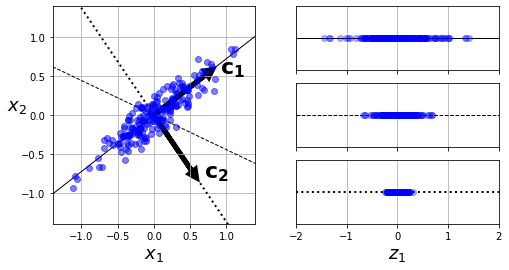

In [30]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

Parece razonable seleccionar el eje que preserva la máxima cantidad de varianza, ya que probablemente perderá menos información que otras proyecciones. Otra forma de justificar esta elección es que es el eje que minimiza la distancia cuadrática media entre el dataset original y su proyección en ese eje. Esta es la idea bastante simple que hay detrás de [PCA](https://homl.info/31).

## Componentes Principales

PCA identifica el eje que reporta la mayor cantidad de varianza en el conjunto de entrenamiento. En la figura anterior se trata de la línea continua. También encuentra un segundo eje, ortogonal al primero, que reporta la mayor cantidad de varianza restante. En este ejemplo 2D no hay elección: es la línea punteada. Si se tratara de un dataset de alta dimensión, PCA también encontraría un tercer eje, ortogonal a ambos ejes anteriores, y un cuarto, un quinto, y así sucesivamente, tantos ejes como número de dimensiones del dataset.

El vector unitario que define el $i^{esimo}$ eje se denomina el *componente principal* (PC) $i^{esimo}$. En la anterior figura que mencionábamos, el $1^{er}$ PC es **$c_1$**, el 2º PC es **$c_2$**. y en la figura siguiente que ya vimos, las dos primeras PC están representadas por las flechas ortogonales en el plano, y la tercera PC sería ortogonal al plano (apuntando hacia arriba o hacia abajo).

![dataset_3d_plot](images/ch08/dataset_3d_plot.png)

---

La dirección de los componentes principales no es estable: si perturbamos ligeramente el conjunto de entrenamiento y ejecutamos de nuevo PCA, algunos de los nuevos PCA pueden apuntar en la dirección contraria a los PCs originales. Sin embargo, generalmente seguirán en el mismo eje. En algunos casos, una par de PCs pueden rotar o intercambiarse, pero el plano que definen generalmente seguirá siendo el mismo.

---

Entonces, ¿cómo encontrar los componentes principales en un conjunto de entrenamiento? Afortunadamente, existe una técnica estándar de factorización de matriz llamada *Descomposición de Valor Singular* (SVD - *Singular Value Decomposition*) que puede descomponer la matrix **X** del conjunto de entrenamiento en la matriz multiplicación de tres matrices $U \sum V^T$, donde **V** contiene todos los componentes principales que estamos buscando, como se muestra en la siguiente ecuación.

***Matriz de componentes principales***

![PC_matrix](images/ch08/PC_matrix.png)

El siguiente código Python usa la función `svd()` de NumPy para obtener todos los componentes principales del conjunto de entrenamiento y luego extraer los primeros dos PCs:

In [31]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

---

PCA asume que el dataset está centrado alrededor del origen. Como veremos, las clases PCA de Scikit-Learn se encargan de centrar los datos por nosotros. Sin embargo, si implementamos PCA por nosotros mismos (como en el ejemplo anterior), o si usamos otras librerías, no debemos olvidar centrar primero los datos.

---

## Proyectando hacia *d* Dimensiones

Una vez que hemos identificado todos los componentes principales, podemos reducir la dimensión del dataset  bajando a *d* dimensiones proyectándolo en el hiperplano definido por los primeros *d* componentes principales. Seleccionar este hiperplano asegura que la proyección preservará tanta varianza como sea posible. Por ejemplo, en la figura anterior el dataset 3D es proyectado hacia abajo al plano 2D definido por los primeros dos principales componentes, preservando una gran parte de la varianza del dataset. Como resultado, la proyección 2D se parece mucho al dataset 3D original.

Para proyectar el conjunto de entrenamiento en el hiperplano, simplemente podemos calcular la matriz multiplicación de la matriz **X** del conjunto de entrenamiento por la matriz **W**$_d$, definida como la matriz que contiene los primeros *d* componentes principales (es decir, la matriz compuesta de las primeras *d* columnas de **V**), como se muestra en la siguiente ecuación.

***Proyectar hacia abajo el conjunto de entrenamiento a d dimensiones***

**X**$_{d-proy}$ = **XW**$_d$

El siguiente código Python proyecta el conjunto de entrenamiento en el plano definido por los primeros dos componentes principales:

In [32]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

¡Ahí lo tenemos! Ya sabemos cómo reducir la dimensión de cualquier dataset a cualquier número de dimensiones hacia abajo, mientras preservamos la mayor varianza posible.

## Usando Scikit-Learn

La clase PCA de Scikit-Learn implementa PCA usando descomposición SVD como ya vimos anteriormente. El código siguiente aplica PCA para reducir la dimensión del dataset a dos dimensiones (tengamos en cuenta que se encarga automáticamente de centrar los datos):

In [33]:
# Contruimos el dataset 3D

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

Después de entrenar el transformador PCA en el dataset podemos acceder a los componentes principales usandor la variable `components_` (tengamos en cuenta que contiene los PCs como vectores horizontales, así, por ejemplo, el primer componente principal es igual a `pca.components_.T[:, 0]`)

## Ratio de varianza explicada

Otra información muy útil es el *ratio de varianza explicada* de cada componente principal, disponible a través de la variable `explained_variance_ratio`. Indica la proporción de la varianza del dataset que se encuentra a lo largo del eje de cada componente principal. Por ejemplo, veamos los ratios de varianza explicada de los primeros dos componentes principales del dataset 3D representando en la figura anterior:

In [35]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

Esto nos dice que el 84,2% de la varianza del dataset se encuentra a lo largo del primer eje y que el 14,6% se encuentra a lo largo del segundo eje. Esto deja menos del 1,2% para el tercer eje, por lo que es razonable asumir que contenga poca información.

## Elegir el número correcto de dimensiones

En lugar de elegir arbitrariamente el número de dimensiones a reducir, normalmente es preferible elegir el número de dimensiones que se necesitan para obtener una porción suficientemente grande de varianza (por ejemplo, 95%). A menos, por supuesto, que estemos reduciendo dimensiones para visualización de datos -en cuyo caso, normalmente, querremos reducir la dimensión a 2 ó 3.

El siguiente código calcula PCA sin reducir la dimensión, luego calcula el número mínimo de dimensiones requeridas para preservar el 95% de la varianza del conjunto de entrenamiento:

In [36]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [37]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [38]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

Luego podemos establecer `n_components=d` y ejecutar PCA de nuevo. Sin embargo, existe una opción mejor: en lugar de especificar el número de componentes principales que queremos preservar, podemos establecer que `n_components` sea un float entre `0.0` y `1.0`, indicando el ratio de varianza que queremos preservar:

In [39]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

np.sum(pca.explained_variance_ratio_)

0.9503684424557436

Otra opción más es dibujar la varianza explicada como una función del número de dimensiones (simplemente dibujando `cumsum`; ver la siguiente figura). Por lo general, habrá un codo en la curva, donde la varianza explicada dejará de crecer rápidamente. Podemos pensar en esto como la dimensión intrínseca del dataset. En este caso, podemos ver que reducir la dimensión hasta aproximadamente 100 dimensiones no perdería demasiada varianza explicada.

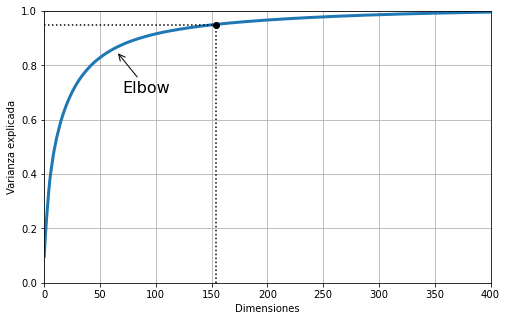

In [40]:
plt.figure(figsize=(8,5))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensiones")
plt.ylabel("Varianza explicada")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)

## PCA para compresión

Obviamente, después de reducir la dimensión el conjunto de entrenamiento ocupa mucho menos espacio. Por ejemplo, intentemos aplicar PCA al dataset MNIST mientras preservamos el 95% de su varianza. Deberíamos encontrar que cada instancia tendrá poco más de 150 características, en lugar de las 784 originales. Entonces, aunque se conserva la mayoría de la varianza, ¡ahora el dataset es menos del 20% de su tamaño original! Esto es un ratio de compresión razonable y podemos ver cómo esto acelera tremendamente un algoritmo de clasificación (por ejemplo un clasificador SVM)

También es posible descomprimir el dataset reducido para volver a las 784 dimensiones aplicando la transformación inversa de la proyección de PCA. Por supuesto esto no nos devolverá los datos originales, dado que la proyección perdió un poco de información (dentro del 5% de la varianza que se eliminó), pero es probable que esté bastance cerca de los datos originales. La distancia cuadrática media entre los datos originales y los datos reconstruidos (comprimidos y después descomprimidos) se denomina *error de reconstrucción*. Por ejemplo, el código siguiente comprime el dataset MNIST a 154 dimensiones, después usa el método `inverse_transform()` para descomprimirlo y volver a las 784 dimensiones. La siguiente figura muestra algunos dígitos del conjunto de entrenamiento original (a la izquierda) y los correspondientes dígitos después de la compresión y descompresión. Podemos ver que existe una ligera pérdida de calidad de imagen, pero los dígitos están casi intactos.

In [41]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [42]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Comprimido')

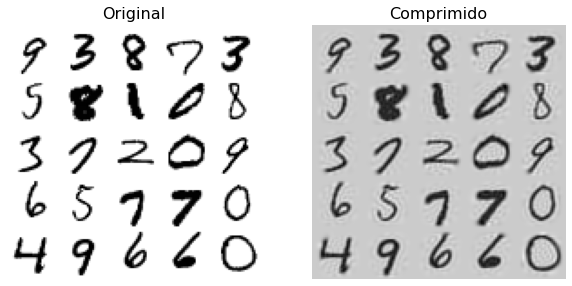

In [43]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Comprimido", fontsize=16)

In [44]:
X_reduced_pca = X_reduced

La ecuación de la transformación inversa se muestra a continuación:
    
***Transformación inversa de PCA, vuelta al número original de dimensiones***

**X**$recuperada$ = **X**$d-proy$ **W**$_d^T$

## PCA aleatorio

Si establecemos el hiperparámetro `svd_solver` a "`randomized`", Scikit-Learn usa un algoritmo estocástico llamado *PCA aleatorio* que encuentra rápidamente una solución de los primeros *d* componentes principales. Su complejidad computacional es *O(m $\times \,d^2$)* + *O(d$^3$)*, en lugar de *O(m $\times \,n^2$)* + *O(n$^3$)* para el enfoquie SVD completo, así que es muchísimo más rápido que SVD completo cuando *d* es mucho más pequeño que *n*:

In [45]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

Por defecto, `svd_solver` está establecido en realidad a `auto`: Scikit-Learn usa automáticamente el algoritmo PCA aleatorio si *m* o *n* es mayor que 500 y *d* es menor que el 80% de *m* o *n*, en caso contrario usa el enfoque SVD completo. Si queremos forzar que Scikit-Learn use SVD completo, podemos establecer el hiperparámetro `svd_solver` a "`full`".

## PCA incremental

Un problema con las implementaciones precedentes de PCA es que requieren que todo el conjunto de entrenamiento se ajuste a la memoria para que el algoritmo se ejecute. Afortunadamente, se han desarrollado algoritmos *PCA incrementales (IPCA)*: podemos dividir el conjunto de entrenamiento en mini-lotes y alimentar un algoritmo IPCA con un mini-lote cada vez. Esto es útil para grandes conjuntos de entrenamiento y también para aplicar a PCA online (es decir, al vuelo, a medida que llegan nuevas instancias).

El siguiente código divide el dataset MNIST en 100 mini-lotes (usando la función `array_split()` de NumPy y después alimenta a la clase [`IncrementalPCA`](https://homl.info/32) de Scikit-Learn para reducir la dimensión del dataset a 154 dimensiones (justo como antes). Observemos que debemos llamar al método `partial_fit()` con cada mini-lote, en lugar del método `fit()` con todo el conjunto de entrenamiento.

In [46]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") 
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [47]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

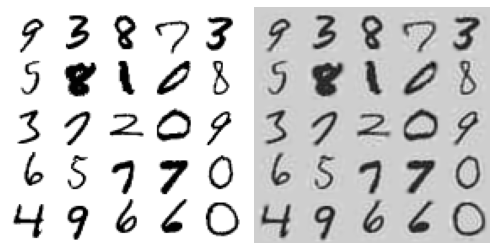

In [48]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [49]:
X_reduced_inc_pca = X_reduced

Vamos a comparar los resultados de transformat MNIST usando PCA regular y PCA incremental. Primero, las medias son iguales:

In [50]:
np.allclose(pca.mean_, inc_pca.mean_)

True

Pero los resultados nos son exactamente idénticos. PCA incremental proporciona una muy buena solución aproximada, pero no es perfecto:

In [51]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

Alternativamente, podemos usar la clase `memmap` de NumPy, que nos permite manipular una gran array almacenado en binario en disco como si estuviera enteramente en memoria; la clase carga en memoria solo los datos que necesita, cuando los necesita. Dado que la clase `incrementalPCA` solo usa una pequeña parte del array en un momento dado, el uso de memoria permanece bajo control. Esto hace posible llamar al método `fit()` usual, como podemos ver en el siguiente código.

Creemos la estructura `memmap()` y copiemos los datos MNIST en ella. Esto normalmente lo haría un primer programa:

In [52]:
filename = "data/my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

Ahora, eliminar el objeto `memmap()` activará su finalizador de Python, lo que garantiza que los datos se guarden en el disco.

In [53]:
del X_mm

Después, otro programa podrá cargar los datos y usarlos para entrenamiento:

In [54]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [55]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Complejidad de tiempo

Como complemente a lo visto, comparemos PCA regular contra PCA incremental y PCA aleatorizada, para varios componentes principales:

In [56]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 1.3 seconds
    IncrementalPCA: 37.3 seconds
    PCA: 1.2 seconds
n_components = 10
    PCA: 1.3 seconds
    IncrementalPCA: 37.8 seconds
    PCA: 1.2 seconds
n_components = 154
    PCA: 4.0 seconds
    IncrementalPCA: 48.1 seconds
    PCA: 3.9 seconds


Ahora comparemos PCA y PCA aleatorio para datasets de diferentes tamaños (número de instancias):

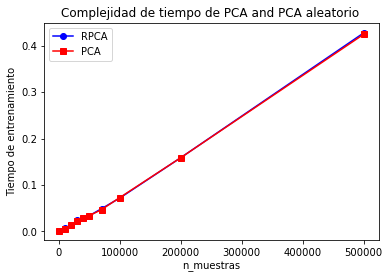

In [57]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_muestras")
plt.ylabel("Tiempo de entrenamiento")
plt.legend(loc="upper left")
plt.title("Complejidad de tiempo de PCA and PCA aleatorio ");

Y ahora comparemos sus ejecuciones en datasets de 2.000 instancias con varias cantidades de características:

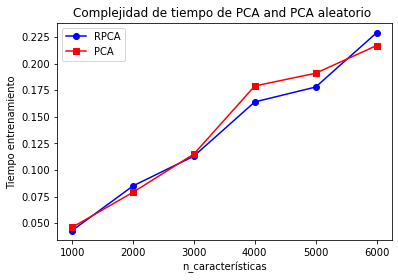

In [58]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_características")
plt.ylabel("Tiempo entrenamiento")
plt.legend(loc="upper left")
plt.title("Complejidad de tiempo de PCA and PCA aleatorio ");

# Kernel PCA

En el capítulo 5 discutimos el truco del kernel, una técnica matemática que implícitamente mapea instancias en un espacio de muy alta dimensión (denominado *espacio de características*), permitiendo la regresión y clasificación no lineales con Máquinas de Soporte Vectorial (SVM). Recordemos que un límite de decisión lineal en un espacio de características de alta dimensión corresponde a un límite de decisión no lineal complejo en el *espacio original*.

Resulta que el mismo truco puede ser aplicado a PCA, haciendo posible ejecutar proyecciones no lineales complejas para reducción de dimensionalidad. Esto se denominal [*Kernel PCA* (kPCA)](https://homl.info/33). A menudo es bueno preservar clusters de instancias después de la proyección, o algunas veces incluso desenrrollar datasets que se encuentran cerca de un manifold girado o enrollado.

Por ejemplo, el siguiente código unsa la clase `KernelPCA` de Scikit-Learn para ejecutar kPCA con un kernel RBF (véase el capítulo 5 para más detalles sobre el kernel RBF y los otros kernels):

In [59]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [60]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

La siguiente figura muestra el rollo suizo reducido a dos dimensiones usando un kernel lineal (equivalente a simplemente usar la clase `PCA`), un kernel RBF y un kernel sigmoide (logístico).

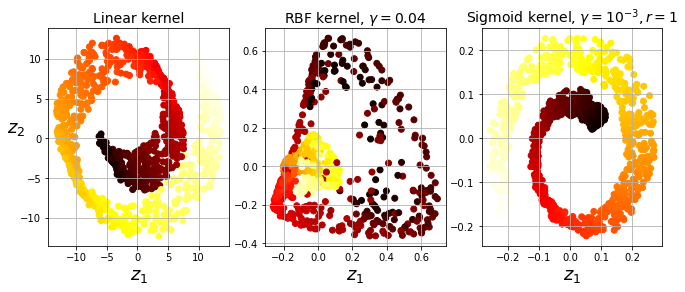

In [61]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

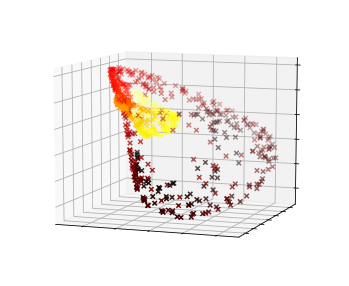

In [62]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

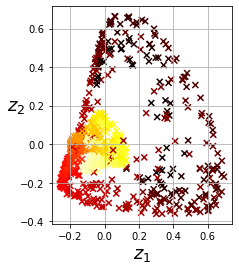

In [63]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

## Seleccionar un Kernel y ajustar hiperparámetros

Como kPCA es un algoritmo de aprendizaje no supervisado, no existe una medida del rendimiendo obvia para ayudar a seleccionar el mejor kernel y los valores de los hiperparámetros. Sin embargo, la reducción de la dimensionalidad es a menudo un paso de preparación para una tarea de aprendizaje supervisado (por ejemplo, clasificación), así que podemos usar simplemente grid search para seleccionar el kernel y los hiperparámetros que conducen al mejor rendimiendo en esa tarea. Por ejemplo, el siguiente código crea un pipeline de dos pasos, primero reduciendo la dimensionalidad a dos dimensiones usando kPCA y luego aplicando Regresión Logística para la clasificación. Después usa `GridSearchCV` para encontrar el mejor kernel y el valor de gamma para kPCA con el fin de obtener la mejor precisión de clasificación al final del pipeline:

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

El mejor kernel e hiperparámetros están disponibles a través de la variable `best_params_`:

In [65]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


Otro enfoque, esta vez enteramente no supervisado, es seleccionar el kernel e hiperparámetros que producen el menor error de reconstrucción. Sin embargo, la reconstrucción no es tan fácil como con PCA lineal. Este es el porqué. La siguiente figura muestra el dataset 3D original del rollo suizo (superior izquierda) y el dataset 2D resultante tras aplicar kPCA usando un kernel RBF (superior derecha). Gracias al truco del kernel, esto es equivalente matemáticamente a mapear el conjunto de entrenamiento a un espacio de características de dimensión infinita (inferior derecha) usando el *mapa de características φ*, y luego proyectar el conjunto de entrenamiento transformado a 2D usando PCA lineal. Tengamos en cuenta que si pudiéramos invertir el paso de PCA lineal para una instancia dada del espacio reducido, el punto reconstruído estaría en el espacio de características, no en el espacio original (por ejemplo, como el representado por una x en el diagrama). Dado que el espacio de características es de dimensión infinita, no podemos calcular el punto reconstruido y, por lo tanto, no podemos calcular el error de reconsutrucción verdadero. Afortunadamente, es posible encontrar un punto en el espacio original que se mapearía cerca del punto reconstruido. Esto se denomina reconstrucción *pre-imagen*. Una vez que tenemos esta pre-imagen, podemos medir su distancia cuadrática a la instancia original. Entonces podemos seleccionar el kernel y los hiperparámetros que minimizan esta error de reconstrucción pre-imagen.

![pre_image](images/ch08/pre_image.png)

Tal vez nos preguntemos cómo realizar esta reconstrucción. Una solución es entrenar un modelo de regresión supervisado, con las instancias proyectadas como el conjunto de entrenamiento y las instancias originales como los objetivos. Scikit-Learn lo hará automáticamente si configuramos `fit_inverse_transform = True`, como se muestra en el siguiente código:

In [66]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

---

Por defecto, `fit_inverse_transform=False` y `KernelPCA` no tiene método `inverse_transform()`. Este método solo se crea cuando se configura `fit_inverse_transform=True`

---

In [67]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576614

Ahora podemos usar grid search con validación cruzada para encontrar el kernel y los hiperparámetros que minimizan este error de reconstrucción pre-imagen.

# LLE

[*Embebido local lineal (LLE - Locally Linear Embedding)*](https://homl.info/35) es otra poderosa técnica de reducción dimensional no lineal. Es una técnica de aprendizaje Manifold que no se basa en proyecciones como los algoritmos anteriores. En pocas palabras, LLE trabaja midiendo primero cómo cada instancia de entrenamiento se relaciona linealmente con sus vecinas más cercanas y después buscando una representación de menor dimensión del conjunto de entrenamiento donde esas relaciones estén mejor preservadas. Esto lo hace particularmente bueno para desenrrollar manifolds, especialmente cuando no hay demasiado ruido.

Por ejemplo, el siguiente código usa la clase `LocallyLinearEmbedding` de Scikit-Learn para desenrrollar el rollo suizo. El dataset 2D resultante se muestra en la siguiente figura. Como podemos ver, el rollo suizo está completamente desenrrollado y las distancias entre instancias están localmente bien conservadas. Sin embargo, las distancias no se conservan a mayor escala: la parte izquierda del rollo suizo se estira, mientras que la parte de la derecha se aprieta. Sin embargo, LLE hizo un trabajo bastante bueno modelando el manifold.

In [68]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [69]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

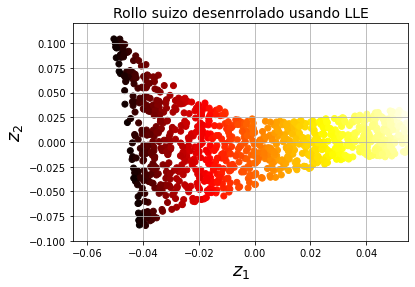

In [70]:
plt.title("Rollo suizo desenrrolado usando LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

Así es como funciona LLE: primero, por cada instancia de entrenamiento **x**$^{(i)}$, el algoritmo identifica sus vecinos más cercanos *k* (en el código anterior *k* = 10), luego intenta reconstruir **x**$^{(i)}$ como una función lineal de estos vecinos. Más específicamente, encuentra los pesos *w*$_{i,j}$ tales que la distancia cuadrática entre **x**$^{(i)}$ y $\sum_{j=1}^m$ *w*$_{i,j}$ **x**$^{(j)}$ sea lo más pequeña posible, asumiendo que *w*$_{i,j}$ = 0 si **x**$^{(j)}$ es uno de los *k* vecinos más cercanos de **x**$^{(i)}$. Por lo tanto, el primer paso de LLE es el problema de optimización restringida que se describe en la siguiente ecuación, donde **W** es la matriz de pesos conteniendo todos los pesos *w*$_{i,j}$. La segunda restricción simplemente normaliza los pesos por cada instancia de entrenamiento **x**$^{(i)}$.

***LLE paso 1: modelando linealmente las relaciones locales***

![ecuation_lle](images/ch08/ecuation_lle.png)

Después de este paso, la matriz de pesos **$\hat{W}$** (conteniendo los pesos $\hat{w}_{i,j}$) codifica las relaciones lineales locales entre las instancias de entrenamiento. Ahora el segundo paso es mapear las instancias de entrenamiento en un espacio *d*-dimensional (donde *d < n*), preservando estas relaciones locales tanto como sea posible. Si **z$^{(i)}$** es la imagen de **x$^{(i)}$** en este espacio *d*-dimensional, entonces queremos que la distancia cuadrática entre **z$^{(i)}$** y $\sum_{j=1}^m$ $\hat{w}_{i,j}$ **z$^{(j)}$** sea lo más pequeña posible. Esta idea lleva al problema de optimización no restringido descrito en la siguiente ecuación. Parece muy similar al primero paso, pero en lugar de mantener las instancias fijas y buscar los pesos óptimos, lo hacemos a la inversa: mantenemos los pesos fijos y buscamos la posición óptima de las imágenes de las instancias en el espacio de menor dimensión. Tengamos en cuenta que **Z** es la matriz conteniendo todas las **z$^{(i)}$**.

***LLE paso 2: reduciendo dimensionalmente mientras preservamos ralaciones***

![ecuation_lle_2](images/ch08/ecuation_lle_2.png)

La implementación de LLE de Scikit-Learn tiene la siguiente complejidad computacional: *O*(*m* log(*m*)*n* log(*k*)) para encontrar los *k* vecinos más cercanos, *O*(*mnk$^3$*) para la optimización de los pesos y *O*(*dm$^2$*) para la construcción de las representaciones de menor dimensión. Desafortunadamente, *m$^2$* en el último término hace que este algoritmo escale pobremente en datasets muy grandes.

# Otras técnicas de Reducción de la Dimensionalidad

Existen otras muchas técnicas de reducción de la dimensionalidad, varias de las cuales están disponibles en Scikit-Learn. He aquí algunas de las más populares:

-  *Escalado Multidimiensional (MDS)* reduce la dimensionalidad mientras conserva la distancias entre las instancias.

- *Isomap* crea un crafo conectando cada instancia a sus vecinos más cercanos, luego reduce dimensionalmente mientras intenta concervar las *distancias geodésicas* (la distancia geodésica entre dos nodos en un grafo es el número de nodos del camino más corto entre esos nodos) entre las instancias.

- *Embebido de Vecino Estocástico t-Distribuido (t-SNE, Distributed Stochastic Neighbor Embedding)* reduce dimensionalmente mientras intenta mantener cerca instancias similares y aparte instancias no similares. Es usada principalmente para visualizaciones, en particular para visualizar clusters de instancias en espaciones de alta dimensión (por ejemplo, para visualizar imágenes MNIST en 2D).

- *Análisis Discriminante Lineal* (LDA) es realmente un algoritmo de clasificación, pero durante el entrenamiento aprende los ejes más discriminativos entre las clases, y estos ejes pueden ser usados para definir un hiperplano en el cual proyectar los datos. El beneficio es que la proyección mantendrá las clases tan apartadas como sea posible, por lo que LDA es una buena técnica para reducir la dimensionalidad antes de ejecutar otro algoritmo de clasificación, como un clasificador SVM.

In [71]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [72]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [73]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [74]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

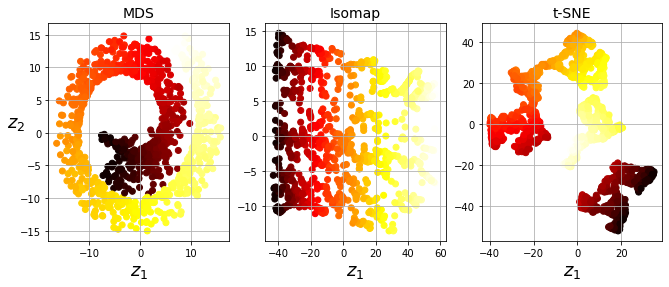

In [75]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

# Ejercicios

## Ej.1

***¿Cuales son las principales motivaciones para reducir la dimensión de un dataset? ¿Cuáles son los principales inconvenientes?***

* Las principales motivaciones para la reducción de la dimensionalidad son:

   - Para acelerar un algoritmo de entrenamiento posterior (en algunos casos, incluso puede eliminar el ruido y las funciones redundantes, haciendo que el algoritmo de entrenamiento funcione mejor).
   - Para visualizar los datos y obtener ideas de las características más importantes.
   - Simplemente para ahorrar espacio (compresión).
 
 
* Los principales inconvenientes son:

   - Se pierde alguna información, posiblemente degradando el rendimiento de algoritmos de entrenamiento posteriores.
   - Puede ser computacionalmente intensivo.
   - Añade alguna complejidad a nuestros pipelines de Machine Learning.
   - A menudo, las características transformadas son más difíciles de interpretar.

## Ej.2

***¿Qué es la maldición de la dimensionalidad?***

La maldición de la dimensionalidad se refiere al hecho de que muchos problemas que no existen en el espacio de baja dimensión surgen en el espacio de alta dimensión. En Machine Learning, una manifestación común es el hecho de que los vectores de alta dimensión muestreados al azar son generalmente muy escasos, lo que aumenta el riesgo de sobreajuste y hace que sea muy difícil identificar patrones en los datos sin tener suficientes datos de entrenamiento.

## Ej.3

***Una vez que se ha reducido la dimensionalidad de un dataset, ¿es posible revertir la operación? ¿Si es así, cómo? ¿Si es que no, por qué?***

Una vez que la dimensionalidad de un dataset se ha reducido utilizando uno de los algoritmos que discutimos, casi siempre es imposible revertir perfectamente la operación, porque parte de la información se pierde durante la reducción de la dimensionalidad. Además, aunque algunos algoritmos (como PCA) tienen un procedimiento de transformación inversa simple que puede reconstruir un dataset relativamente similar al original, otros algoritmos (como T-SNE) no lo hacen.

## Ej.4

***¿Puede ser usado PCA para reducir la dimensionalidad de un dataset altamente no lineal?***

PCA se puede utilizar para reducir significativamente la dimensionalidad de la mayoría de los conjuntos de datos, incluso si son altamente no lineales, porque al menos puede eliminar dimensiones inútiles. Sin embargo, si no hay dimensiones inútiles, por ejemplo, el rollo suizo, la reducción de la dimensionalidad con PCA perderá demasiada información. Deseamos desenrollar el rollo suizo, no aplastarlo.

## Ej.5

***Supongamo que ejecutamos PCA en una dataset 1.000-dimensional, estableciendo el ratio de varianza explicada a 95%. ¿Cuántas dimensiones tendrá el dataset resultante?***

Esa es una pregunta capciosa: depende del dataset. Veamos dos ejemplos extremos. Primero, supongamos que el dataset se compone de puntos que están casi perfectamente alineados. En este caso, PCA puede reducir el dataset a una sola dimensión mientras conserva el 95% de la variación. Ahora imaginemos que el dataset se compone de puntos perfectamente aleatorios, dispersos por todas las 1.000 dimensiones. En este caso, se requieren las 1.000 dimensiones para preservar el 95% de la varianza. Entonces la respuesta es, depende del dataset, y podría ser cualquier número entre 1 y 1.000. Dibujar la varianza explicada en función del número de dimensiones es una forma de tener una idea aproximada de la dimensionalidad intrínseca del dataset.

## Ej.6

***¿En qué casos querríamos usar PCA, PCA incremental, PCA aleatorio o Kernel PCA?***

PCA normal es el valor predeterminado, pero solo funciona si el conjunto de datos cabe en la memoria. PCA incremental es útil para grandes conjuntos de datos que no caben en la memoria, pero es más lenta que la PCA normal, por lo que si el conjunto de datos cabe en la memoria, preferiríamos PCA normal. PCA incremental también es útil para tareas online, cuando necesitamos aplicar PCA sobre la marcha, cada vez que llega una nueva instancia. PCA aleatoria es útil cuando deseamos reducir considerablemente la dimensionalidad y el conjunto de datos cabe en la memoria; en este caso, es mucho más rápido que PCA normal. Finalmente, Kernel PCA es útil para datasets no lineales.

## Ej.7

***¿Cómo podemos evaluar el rendimiento de un algoritmo de reducción dimensional en nuestro dataset?***

Intuitivamente, un algoritmo de reducción de dimensionalidad funciona bien si elimina muchas dimensiones del dataset sin perder demasiada información. Una forma de medir esto es aplicar la transformación inversa y medir el error de reconstrucción. Sin embargo, no todos los algoritmos de reducción de dimensionalidad proporcionan una transformación inversa. Alternativamente, si estamos utilizando la reducción de dimensionalidad como un paso de preprocesamiento antes de otro algoritmo de Machine Learning (por ejemplo, un clasificador random forest), entonces simplemente podemos medir el rendimiento de ese segundo algoritmo; si la reducción de dimensionalidad no pierde demasiada información, entonces el algoritmo debería funcionar tan bien como cuando se usa el dataset original.

## Ej.8

***¿Tiene sentido encadenar dos algoritmos diferentes de reducción dimensional?***

Puede tener sentido encadenar dos algoritmos de reducción de dimensionalidad diferentes. Un ejemplo común es usar PCA para deshacerse rápidamente de una gran cantidad de dimensiones inútiles y luego aplicar otro algoritmo de reducción de dimensionalidad mucho más lento, como LLE. Es probable que este enfoque de dos pasos produzca el mismo rendimiento que usar LLE solamente, pero en una fracción del tiempo.

## Ej.9

***Carga el dataset MNIST y divídelo en un conjunto de entrenamiento y un conjunto de prueba (toma las primeras 60.000 instancias para el entrenamiento y las 10.000 restantes para la prueba). Entrena a un clasificador de random forest en el conjunto de datos y el tiempo que tarda, luego evalúa el modelo resultante en el conjunto de prueba. Luego, usa PCA para reducir la dimensionalidad del conjunto de datos, con una relación de varianza explicada del 95%. Entrena a un nuevo clasificador de random forest en el conjunto de datos reducido y observa cuánto tiempo lleva. ¿El entrenamiento fue mucho más rápido? Luego evalúa el clasificador en el conjunto de prueba: ¿cómo se compara con el clasificador anterior?***

*Carga el dataset MNIST y divídelo en un conjunto de entrenamiento y un conjunto de prueba (toma las primeras 60.000 instancias para el entrenamiento y las 10.000 restantes para la prueba)*

In [76]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

*Entrena a un clasificador de random forest en el conjunto de datos y el tiempo que tarda, luego evalúa el modelo resultante en el conjunto de prueba*

In [77]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [78]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [79]:
print(f"El entrenamiento fueron {t1 - t0:.2f}s")

El entrenamiento fueron 6.44s


In [80]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

*Usa PCA para reducir la dimensionalidad del conjunto de datos, con una relación de varianza explicada del 95%*

In [81]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

*Entrena a un nuevo clasificador de random forest en el conjunto de datos reducido y observa cuánto tiempo lleva. ¿El entrenamiento fue mucho más rápido?*

In [82]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [83]:
print(f"El entrenamiento fueron {t1 - t0:.2f}s")

El entrenamiento fueron 9.45s


¡Oh no! ¡El entrenamiento es en realidad más lento ahora! ¿Como puede ser? Bueno, como vimos en este capítulo, la reducción de dimensionalidad no siempre conduce a un tiempo de entrenamiento más rápido: depende del dataset, el modelo y el algoritmo de entrenamiento. Si pruebas un clasificador softmax en lugar de un clasificador random forest, encontrarás que el tiempo de entrenamiento se reduce en un factor de 3 cuando usa PCA. En realidad, haremos esto en un segundo, pero primero verifiquemos la precisión del nuevo clasificador random forest.

*Luego evalúa el clasificador en el conjunto de prueba: ¿cómo se compara con el clasificador anterior?*

In [84]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

Es común que el rendimiento disminuya ligeramente al reducir la dimensionalidad, porque perdemos alguna señal útil en el proceso. Sin embargo, la caída del rendimiento es bastante grave en este caso. Así que PCA realmente no ayudó: ralentizó el entrenamiento y redujo el rendimiento. :(

Veamos si ayuda cuando se usa la regresión softmax:

In [85]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42, n_jobs=-1)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

In [86]:
print(f"El entrenamiento fueron {t1 - t0:.2f}s")

El entrenamiento fueron 51.79s


In [87]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

De acuerdo, entonces la regresión de softmax tarda mucho más en entrenarse en este dataset que el clasificador de random forest, además de que funciona peor en el conjunto de prueba. Pero eso no es lo que nos interesa en este momento, queremos ver cuánto puede ayudar PCA a la regresión de softmax. Vamos a entrenar el modelo de regresión softmax usando el dataset reducido:

In [88]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42, n_jobs=-1)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [89]:
print(f"El entrenamiento fueron {t1 - t0:.2f}s")

El entrenamiento fueron 13.73s


¡Bien! La reducción de la dimensionalidad condujo a una aceleración de 4X. :) Vamos a comprobar la precisión del modelo:

In [90]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

Una caída muy leve en el rendimiento, que podría ser un precio razonable a pagar por una aceleración 4X, dependiendo de la aplicación.

Así que ahí lo tienes: PCA puede darte una aceleración formidable ... ¡pero no siempre!

## Ej.10

***Usa t-SNE para reducir el dataset MNIST a dos dimensiones y dibujar el resultado usando Matplotlib. Puedes usar un diagrama de dispersión con 10 colores diferentes para representar la clase objetivo de cada imagen. Alternativamente, puedes escribir dígitos coloreados en la ubicación de cada instancia, o incluso trazar versiones reducidas de las imágenes de los mismos dígitos (si trazas todos los dígitos, la visualización será demasiado abarrotada, por lo que debes dibujar una muestra aleatoria o trazar una instancia solo si ninguna otra instancia ya se ha trazado a corta distancia). Deberías obtener una buena visualización con grupos de dígitos bien separados. Intenta usar otros algoritmos de reducción de dimensionalidad como PCA, LLE o MDS y compara las visualizaciones resultantes.***

*Usa t-SNE para reducir el dataset MNIST a dos dimensiones y dibujar el resultado usando Matplotlib. Puedes usar un diagrama de dispersión con 10 colores diferentes para representar la clase objetivo de cada imagen.*

Ya hemos cargado previamente el dataset MNIST.

La reducción de la dimensionalidad en las 60.000 imágenes completas lleva mucho tiempo, así que solo hagamos esto en un subconjunto aleatorio de 10.000 imágenes:

In [96]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

Ahora vamos a usar t-SNE para reducir la dimensionalidad a 2D, así podemos dibujar el dataset:


In [99]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

Ahora vamos a usar la función `scatter()` de Matplotlib para dibujar un gráfico de dispersión, usando diferentes colores para cada gráfico:

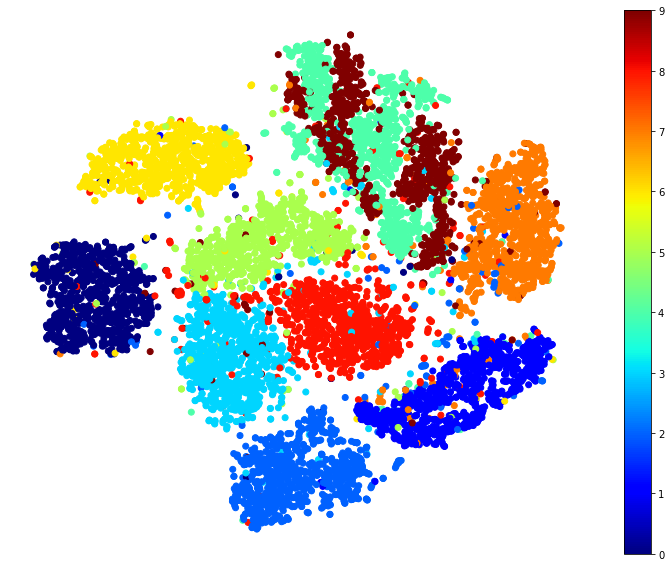

In [100]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

¿No es simplemente hermoso? Este gráfico nos dice qué números son fácilmente distinguibles de los demás (por ejemplo, 0s, 6s y la mayoría de los 8s son grupos bastante bien separados), y también nos dice qué números son a menudo difíciles de distinguir (por ejemplo, 4s y 9s, 5s y 3s, y así sucesivamente).

Centrémonos en los dígitos 3 y 5, que parecen superponerse mucho.

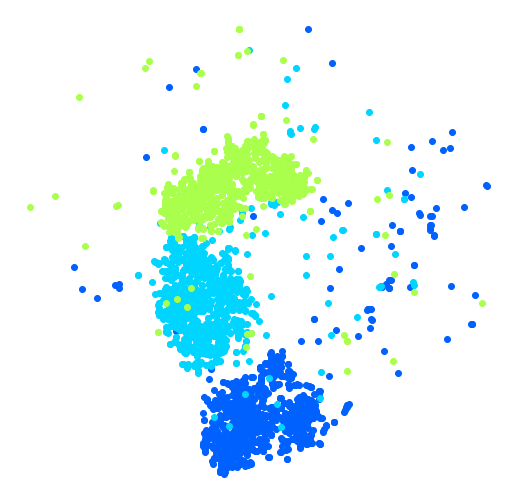

In [101]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Veamos si podemos producir una imagen más agradable ejecutando t-SNE en estos 3 dígitos:

In [103]:
idx = (y == 2) | (y == 3) | (y == 5) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

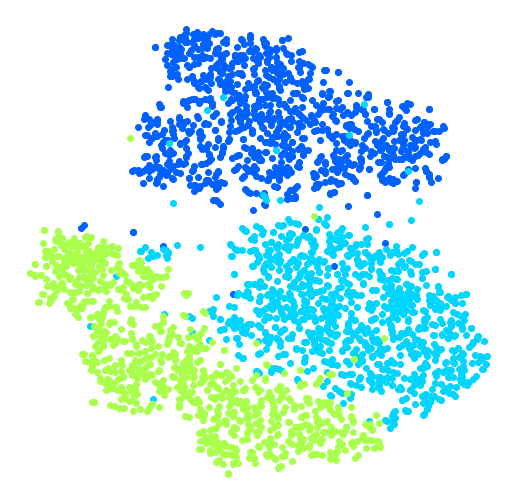

In [104]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Mucho mejor, ahora los grupos tienen mucha menos superposición. Pero algunos 3 están por todas partes. Además, hay dos grupos distintos de 2 y también dos grupos distintos de 5. Sería bueno si pudiéramos visualizar algunos dígitos de cada grupo, para entender por qué este es el caso. Hagámoslo ahora.

*Alternativamente, puedes escribir dígitos coloreados en la ubicación de cada instancia, o incluso trazar versiones reducidas de las imágenes de los mismos dígitos (si trazas todos los dígitos, la visualización será demasiado abarrotada, por lo que debe dibujar un azar muestrear o trazar una instancia solo si ninguna otra instancia ya se ha trazado a corta distancia). Deberías obtener una buena visualización con grupos de dígitos bien separados.*

Creemos una función `plot_digits ()` que dibujará un diagrama de dispersión (similar a los diagramas de dispersión anteriores) además de escribir dígitos coloreados, con una distancia mínima garantizada entre estos dígitos. Si se proporcionan las imágenes de dígitos, se trazan en su lugar. Esta implementación se inspiró en uno de los excelentes ejemplos de Scikit-Learn ([plot_lle_digits](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), basado en un conjunto de datos de dígitos diferente).

In [105]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

¡Vamos a intentarlo! Primero escribamos dígitos de colores:

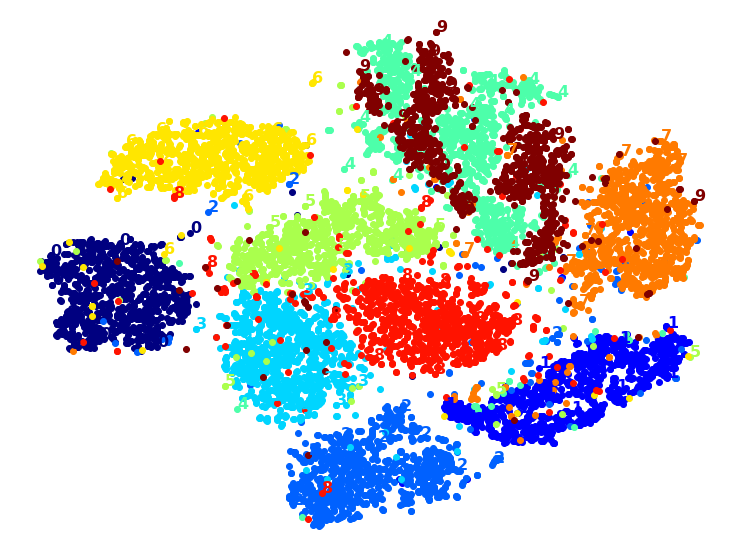

In [106]:
plot_digits(X_reduced, y)

Bueno, está bien, pero no es tan hermoso. Probemos con las imágenes de dígitos:

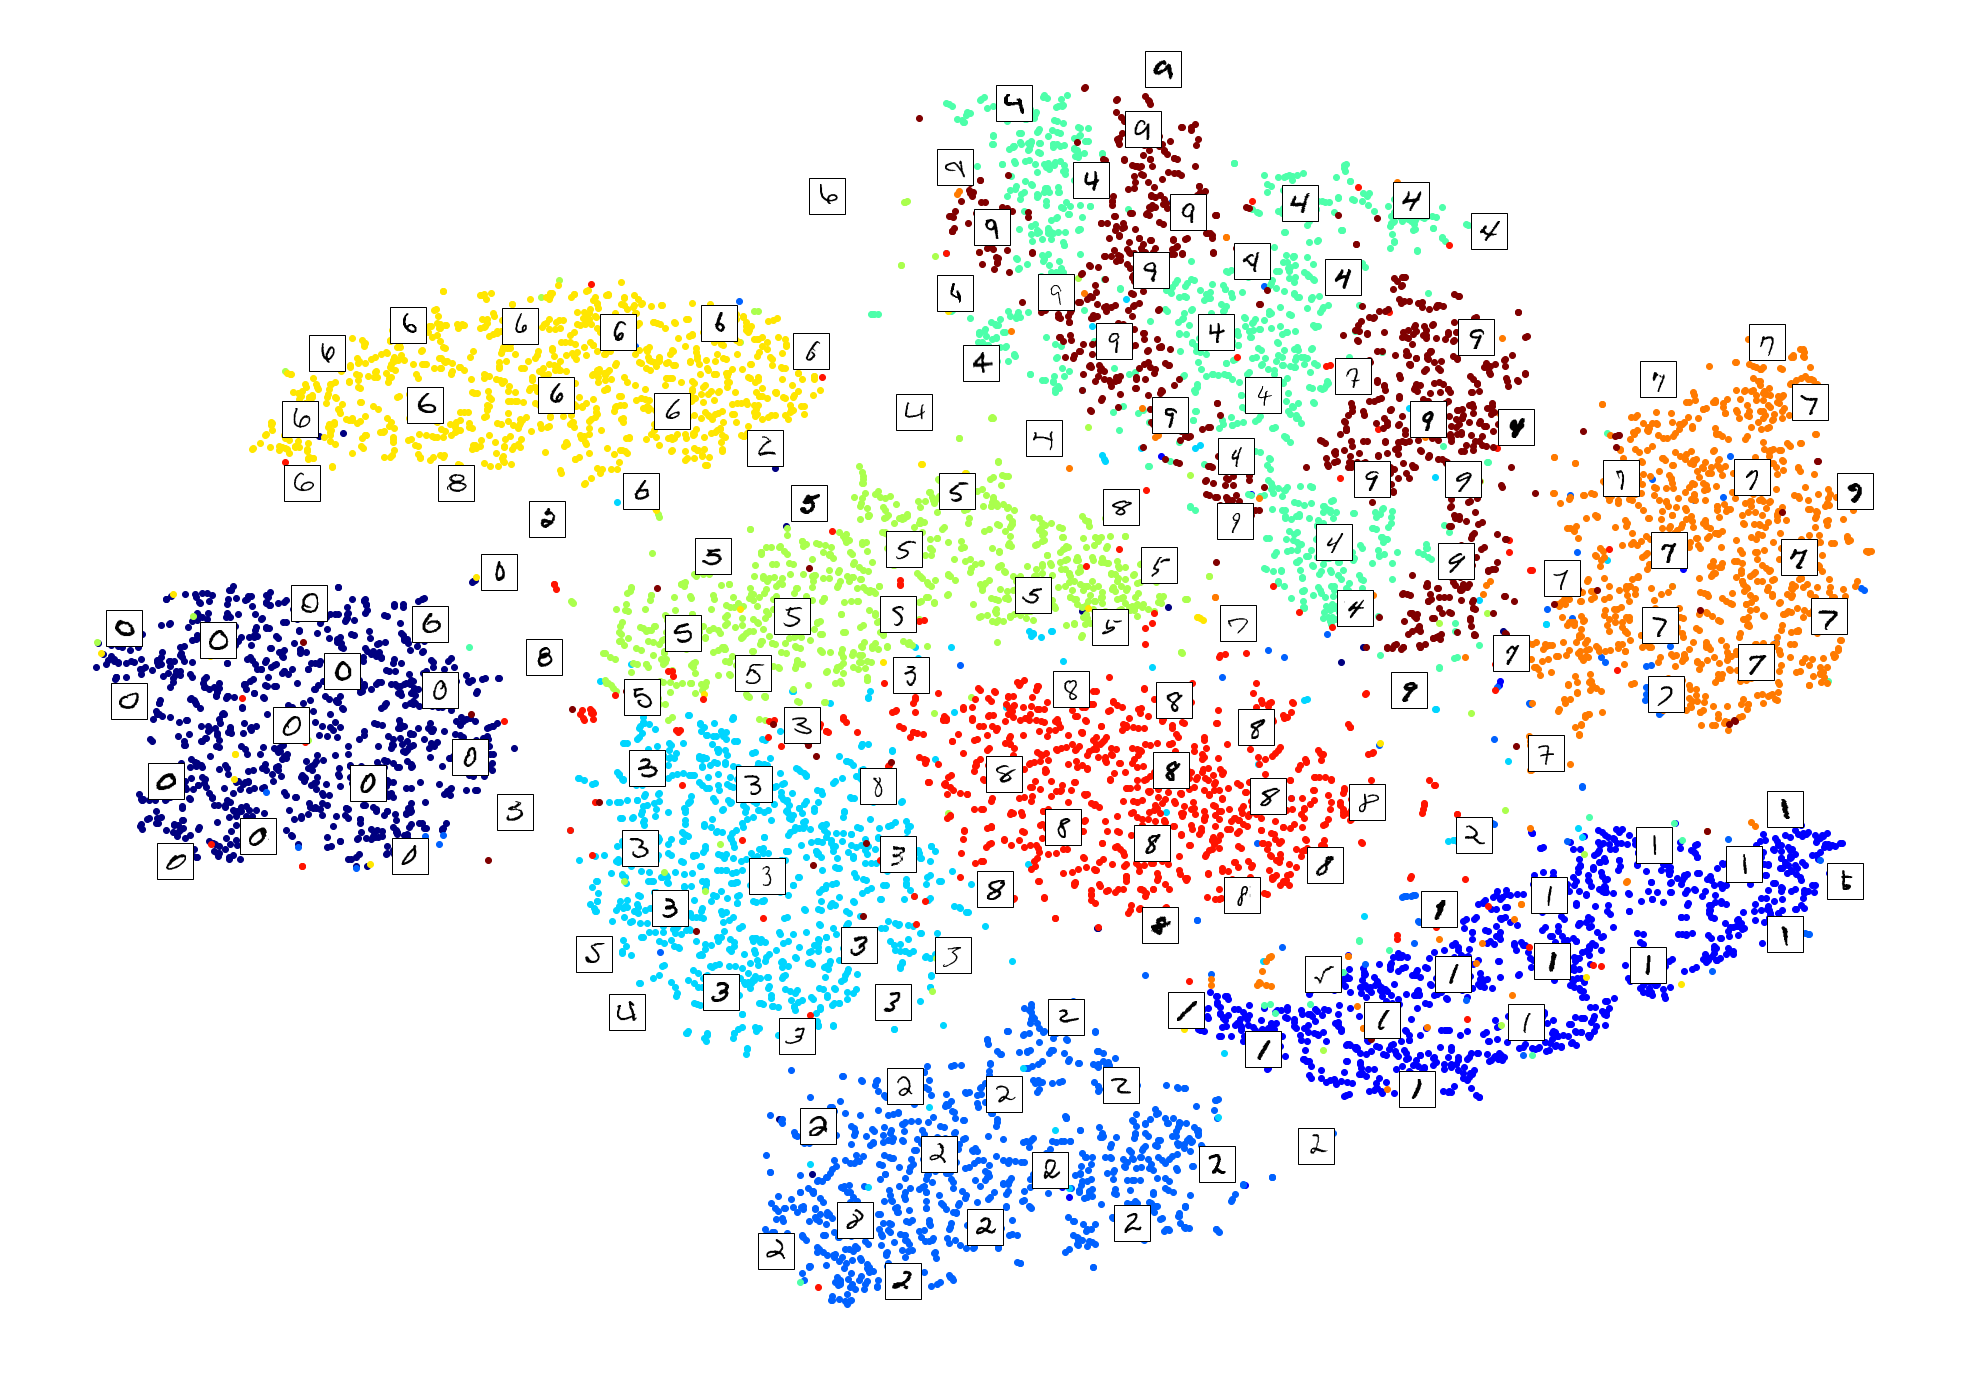

In [107]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

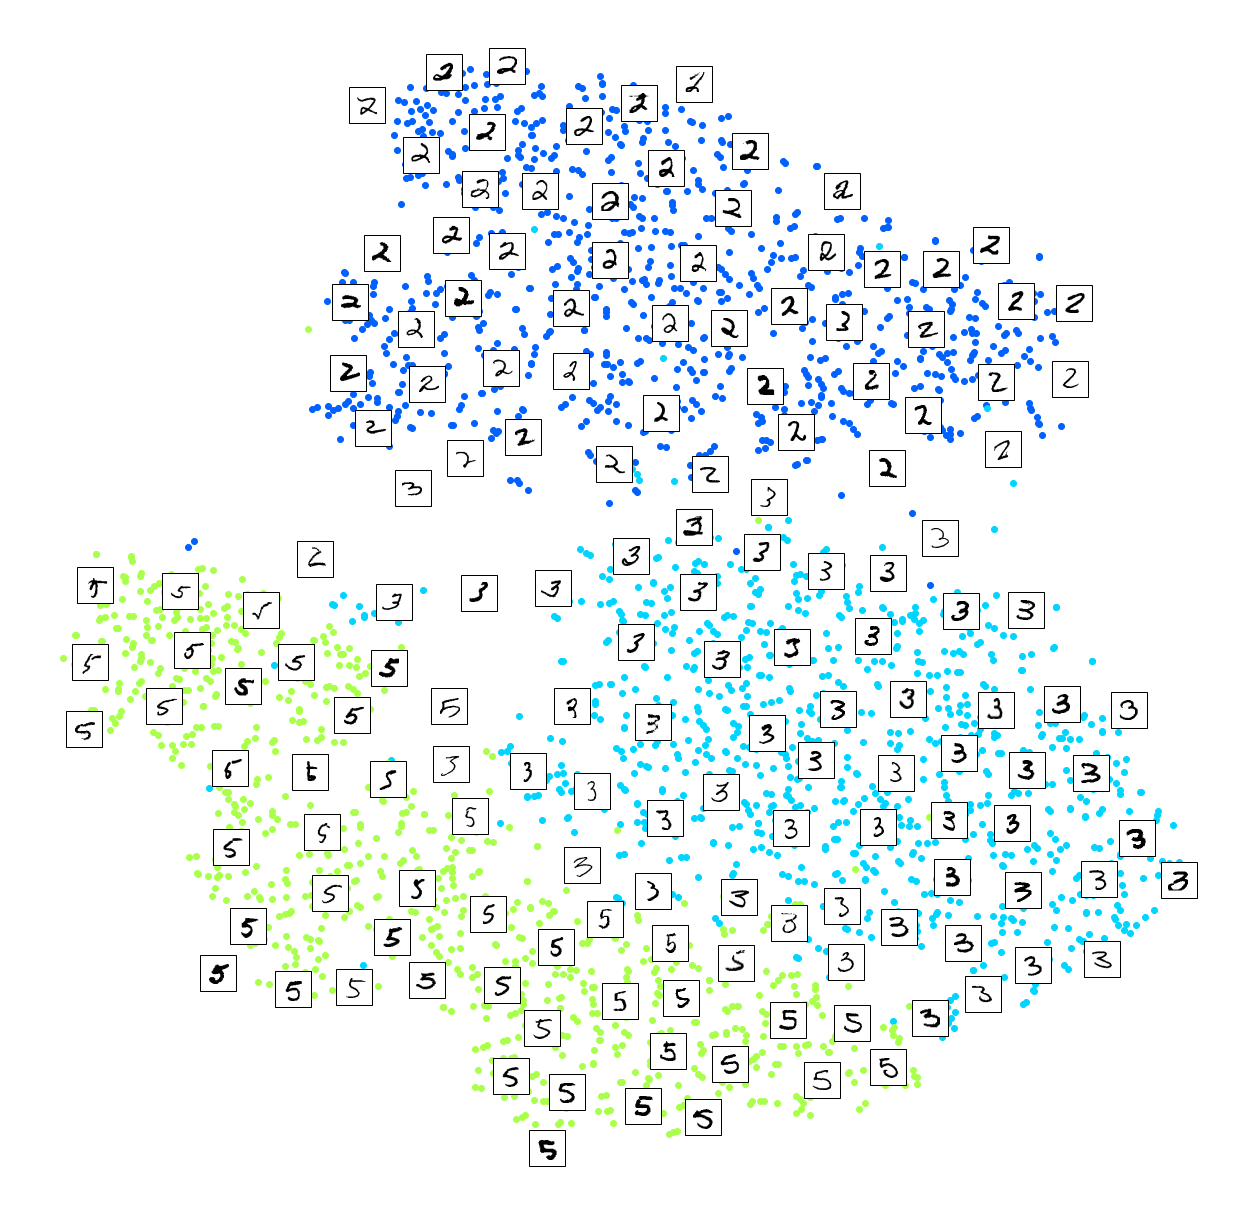

In [108]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

*Intenta utilizar otros algoritmos de reducción de dimensionalidad como PCA, LLE o MDS y compare las visualizaciones resultantes.*

Comencemos con PCA. También calcularemos cuánto tiempo lleva:

PCA took 0.2s.


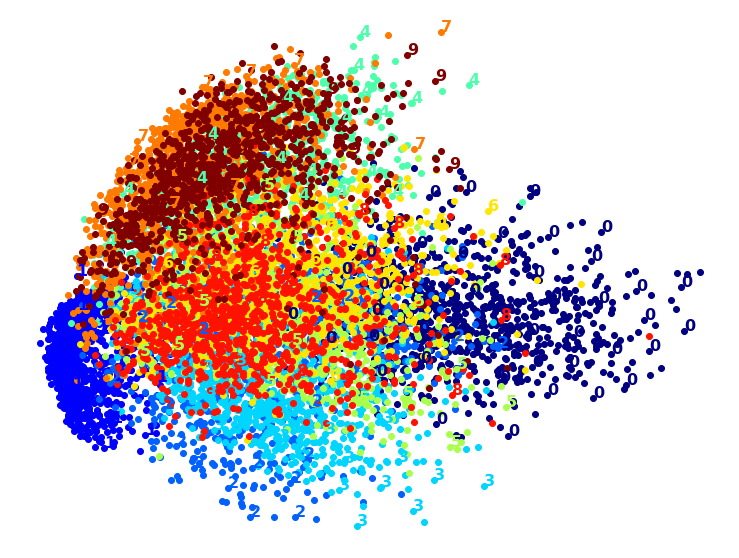

In [109]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

¡Guau, PCA es increíblemente rápido! Pero aunque vemos algunos grupos, hay demasiada superposición. Probemos con LLE:

LLE took 71.2s.


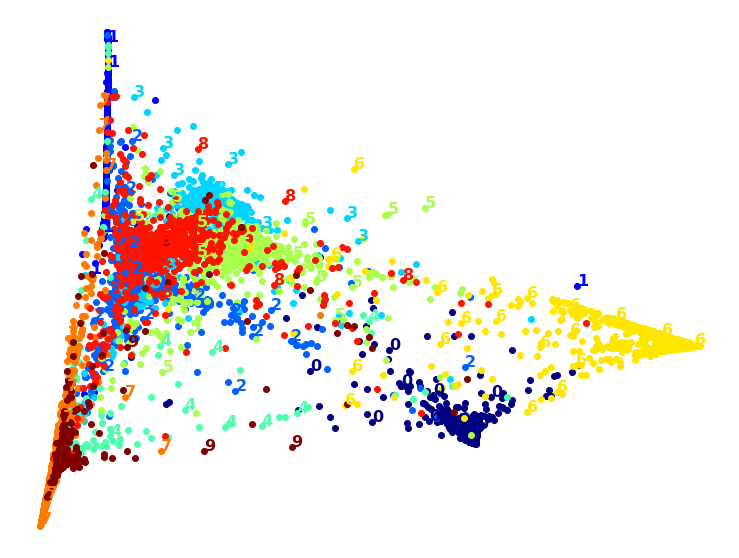

In [110]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42, n_jobs=-1).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

Eso tomó un tiempo y el resultado no se ve muy bien. Veamos qué sucede si primero aplicamos PCA, conservando el 95% de la varianza:

PCA+LLE took 66.5s.


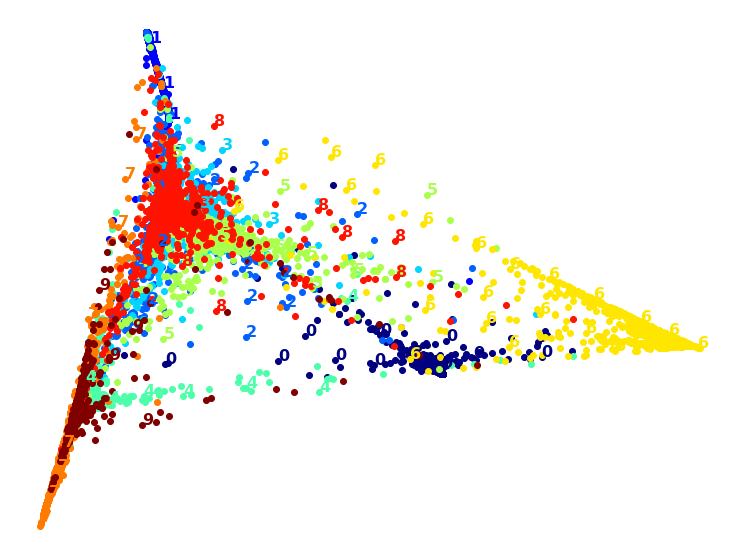

In [115]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42, n_jobs=-1)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

El resultado es más o menos el mismo, pero esta vez fue casi 4 veces más rápido.

Probemos con MDS. Es demasiado largo si lo ejecutamos en 10.000 instancias, así que intentemos 2.000 por ahora:

MDS took 62.8s (on just 2,000 MNIST images instead of 10,000).


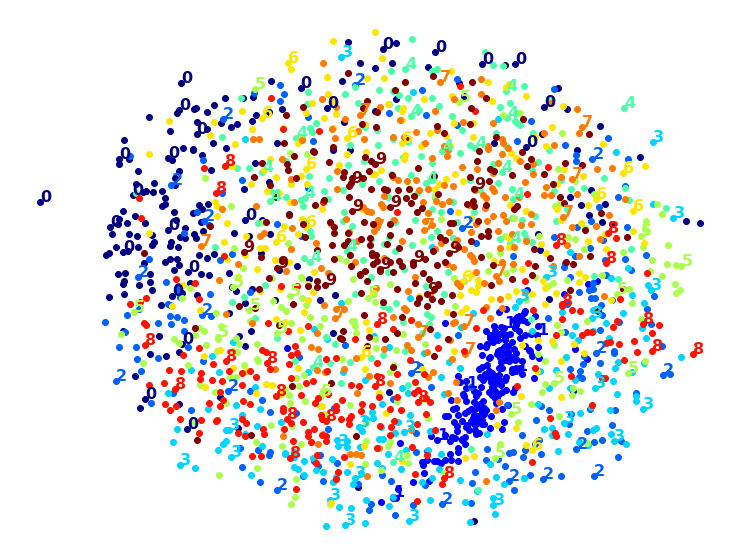

In [112]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42, n_jobs=-1).fit_transform(X[:m])
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

Mmm, esto no se ve muy bien, todos los grupos se superponen demasiado. Probemos primero con PCA, ¿tal vez será más rápido?

PCA+MDS took 64.2s (on 2,000 MNIST images).


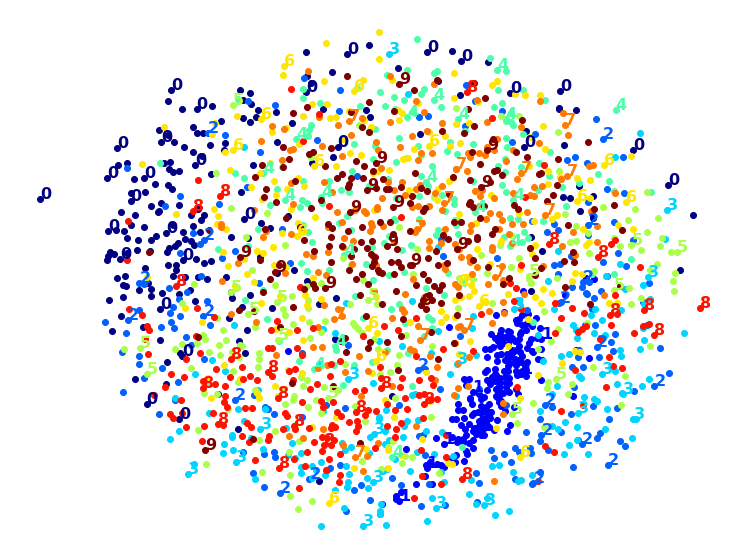

In [116]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42, n_jobs=-1)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

Mismo resultado, y sin aceleración: PCA no ayudó (o perjudicó).

Probemos con LDA:

LDA took 2.1s.


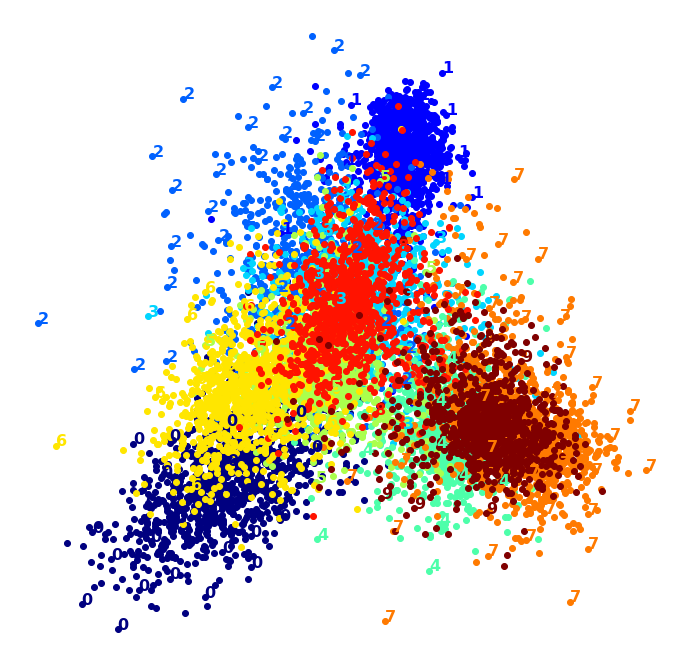

In [117]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

Este es muy rápido, y se ve bien al principio, hasta que te das cuenta de que varios grupos se superponen severamente.

Bueno, está bastante claro que t-SNE ganó esta pequeña competencia, ¿no te parece? No lo cronometramos, así que hagámoslo ahora:

t-SNE took 49.9s.


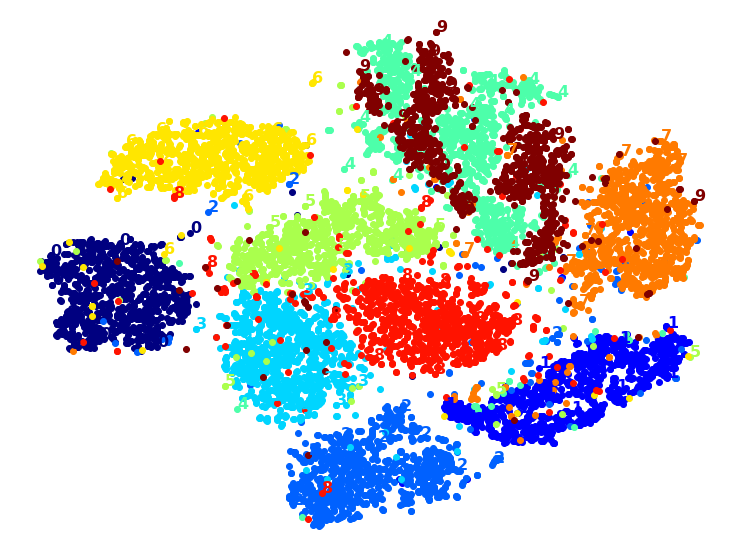

In [118]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42, n_jobs=-1).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

Es dos veces más lento que LLE, pero sigue siendo mucho más rápido que MDS, y el resultado se ve muy bien. Veamos si un poco de PCA puede acelerarlo:

PCA+t-SNE took 37.7s.


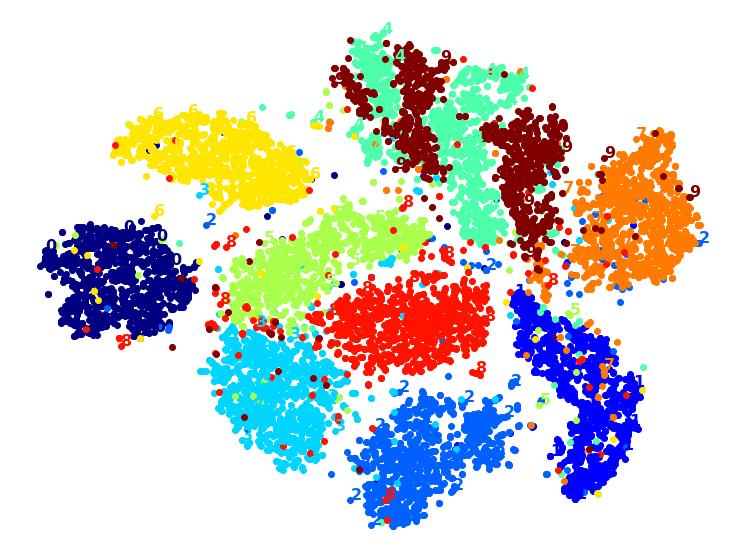

In [119]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42, n_jobs=-1)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

Sí, PCA nos dio aproximadamente un 25% de aceleración, sin dañar el resultado. ¡Tenemos un ganador!